# Problem 2

## Introduction
The image data that will be used for this problem is Brain MRI Images for [Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection). It consists of MRI scans of two classes:

* YES - tumor, encoded as 1. 
* NO - no tumor, encoded as 0

The data set description doesn't hold any more information.It contains 2 folders: yes and no with 253 Brain MRI Images saved as jpeg.The folder yes contains 155 Brain MRI Images that are tumorous and no contains 98 Brain MRI Images that are non-tumorous.

In [98]:
# Import libraries
import os
import glob
import shutil
from random import sample
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import random_split
from torchvision import transforms, datasets
from torchvision.utils import make_grid

#Initialise seed
np.random.seed(701563)

## Preparing Dataset
### Number of images in each class
We can observe that one class has significantly more samples than the other class. In order to prevent the algorithm to have bias towards one of the classes we create a new folder for the yes class with 98 images. 

In [66]:
#Data directory
filepath = '/Users/papagiannizoe/Desktop/MSc-Imperial/Term _4/Unstructured_Data/Assessments/Assessment_1/data'
yes_dir=os.listdir(filepath +'/yes')
no_dir=os.listdir(filepath +'/no')

print("Number of images in yes folder",len(yes_dir))
print("Number of images in yes folder",len(no_dir))

Number of images in yes folder 155
Number of images in yes folder 99


In [67]:
#Create new folder that will contain samples for our model
#Check if folder already exists
if os.path.exists(filepath +'/brain_dataset') is False:
    no_path = filepath +'/no'
    dst_path = filepath +'/brain_dataset/no'
    shutil.copytree(no_path, dst_path)
    yes_path= filepath +'/yes'
    dst_path = filepath +'/brain_dataset/yes'
    shutil.copytree(yes_path, dst_path)

In [68]:
orig_len=len(os.listdir(yes_path))
new_len=len(os.listdir(filepath +'/brain_dataset/yes'))

if new_len==orig_len:
    n_samples=len(yes_dir)-len(no_dir)
    for file in sample(yes_dir,n_samples):
        os.remove(filepath+'/brain_dataset/yes/'+file)
    print("Number of images in yes folder",len(os.listdir(filepath +'/brain_dataset/yes')))

### Visualise Images

Size of Original image: (180, 218)
Size of Original image: (276, 338)


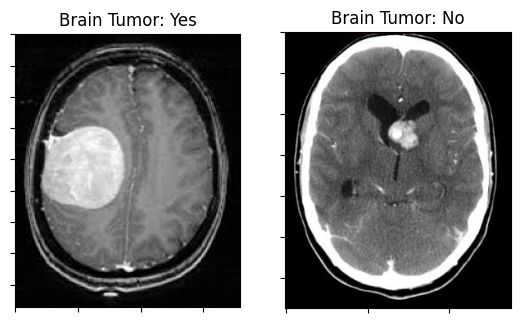

In [65]:
# Tumor
new_filepath=filepath+'/brain_dataset
img_yes = Image.open(filepath + '/yes/Y1.jpg')
img_no = Image.open(filepath + '/no/N1.jpg')
print("Size of Original image:", img_yes.size)
print("Size of Original image:", img_no.size)

fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Brain Tumor: Yes")
ax1.imshow(img_yes)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Brain Tumor: No")
ax2.imshow(img_no)

# Remove tick labels
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

plt.show()

### Check Size of Images 

Next,a scatter plot was created to examine the distribution of the images resolution and establish the ideal dimensions for resizing. The plot below shows that the majority of the images have a resolution of less than 600 by 600. The optimal size seems to be 400 x 400, which is close to the average.

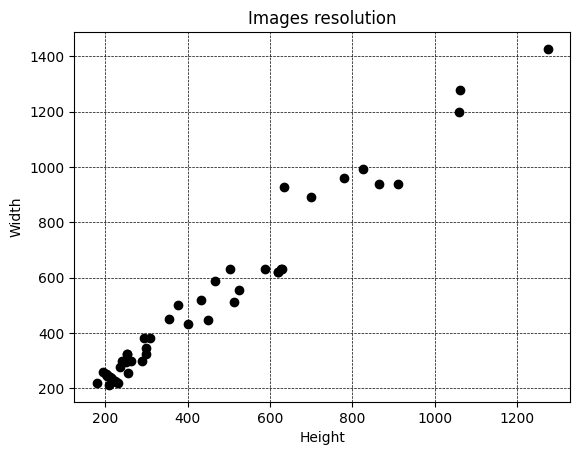

In [69]:
#Initialize list
img_size = []
images = glob.glob(new_filepath + "/yes/*.jpg")
for image in images:
    with open(image, 'rb') as file:
        img = Image.open(file)
        img_size.append(img.size)

# Visualize Image Resolutions
x = [x[0] for x in img_size]
y = [x[1] for x in img_size]

plt.title("Images resolution")
plt.xlabel("Height")
plt.ylabel("Width")
plt.scatter(x, y,color = 'black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
plt.show()

In [70]:
print("Average height and width", sum(x) / len(x), sum(y) / len(y))

Average height and width 431.98 493.34


## Load data using pytoch dataset
The images are loaded using datasets.ImageFolder from torchvision. Next they have to be resized using transforms.Resize() and converted to PyTorch tensors with transforms.ToTensor().

In [78]:
transform_settings = transforms.Compose([transforms.Resize((400, 400)), transforms.ToTensor()])
dataset = datasets.ImageFolder(new_filepath, transform=transform_settings)

#Print first image
img, label = dataset[0]
print(img.shape,label)

print("The classes are: \n",dataset.classes)

torch.Size([3, 400, 400]) 0
The classes are: 
 ['no', 'yes']


The first image in the dataset has 3 channels, heigh 400 and width 400 and it has a label 0 which represents the no class.

## Split the Dataset
We will only use 10% of the dataset for testing and evaluating the model's performance, as the number of samples is limited.To randomly split the images we use  random_split()provided by PyTorch.

In [96]:
n = len(dataset)  # total number of examples
n_train = int(0.90 * n)  # take ~10% for test
# Split Pytorch tensor randomly
train_dataset, test_dataset = random_split(dataset, [n_train, n - n_train])
print("train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

train dataset size: 176
Test dataset size: 20


## Prepare batches
Dataloder function is used to pass samples in “minibatches”. We create two objects `train_loader` and `
test_loader` for training and testing data.

In [80]:
# divide the dataset into batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=False)

## Visualise Images after transformation
The torchvision function `make grid()` is used to view the images of a single batch. 

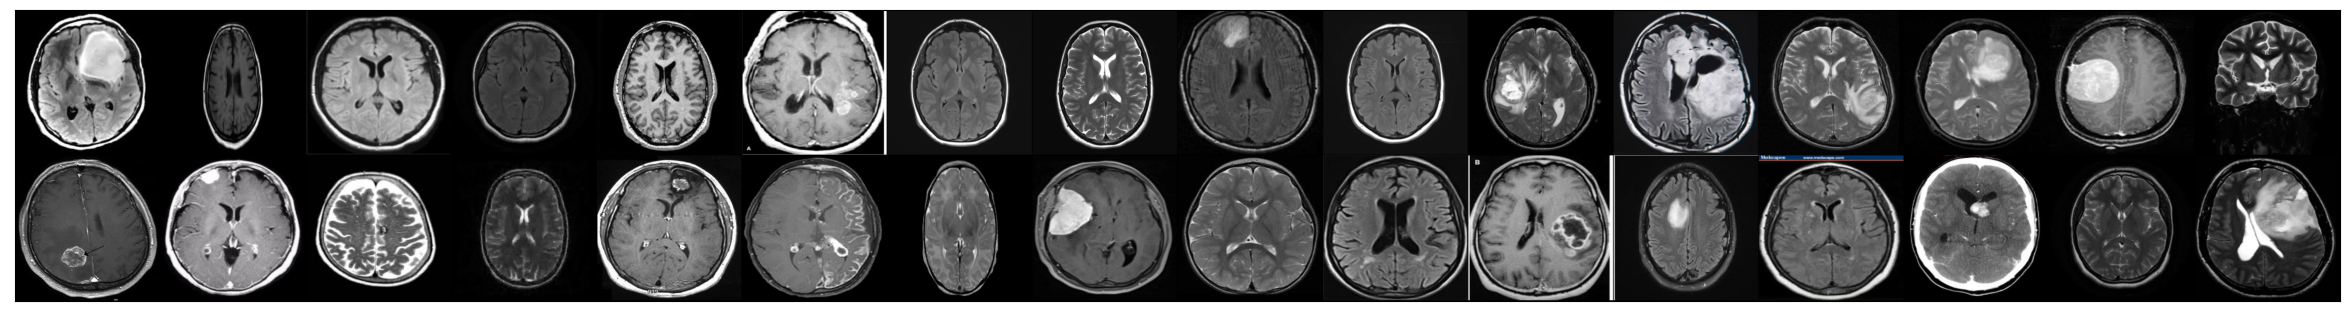

In [84]:
# %%
#Function to visualise batch 
def vis_batch(loader):
    for images, labels in loader:
        fig, ax = plt.subplots(figsize=(30, 18))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


vis_batch(train_loader)

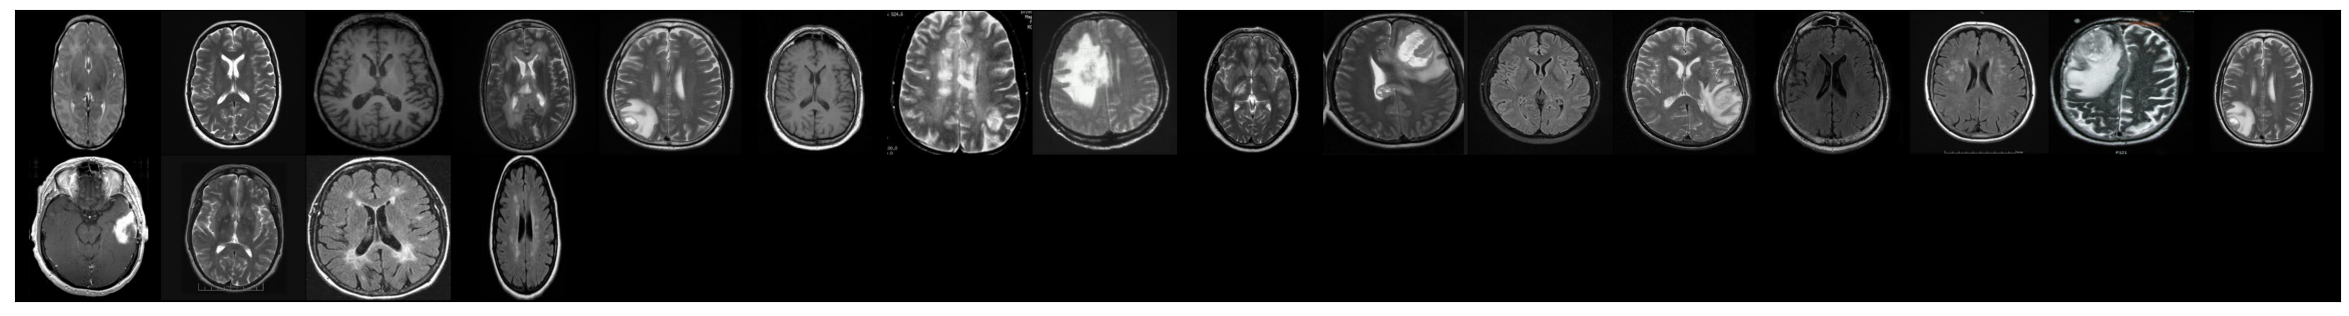

In [86]:
vis_batch(test_loader)

## CNN Model

We prepare a new base class to train and test our model.  According to [pytorch documentation](https://pytorch.org/docs/stable/nn.html#linear-layers):
* The input shape of the image is `(batch_size, channels, depth, height, width)`.
* Conv2d accepts `torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')`. The number of channels in the input image is equal to 3 and we choose the number of channels of the output image to be 8. The kernel size is set to 3.
* The linear layer accepts: `torch.nn.Linear(in_features, out_features, bias=True)`. The `in_features` represents the size of each input sample and is equal to $h_{out}*w_{out}*out\_channels$. In order to find $h_{out},w_{out}$ for the linear layer, we create a function that calculates the size of the images on each layer. According to [Conv2d documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) the output size is equal to:

$$H_{out}=\frac{H_{in}+2 \times padding[0]-dilation[0]\times (kernel\_size[0]-1)-1}{stride[0]}+1$$
$$W_{out}=\frac{W_{in}+2 \times padding[1]-dilation[1]\times (kernel\_size[1]-1)-1}{stride[1]}+1$$

* The last layer is dependent on the classes we want to predict which in this case are equal to 2. 

In [87]:
def conv2dshape(hin, win, layer, pool=2):
    # get conv arguments
    param = layer[0]
    kernel_size = param.kernel_size
    stride = param.stride
    padding = param.padding
    dilation = param.dilation
    
    #Calculate new height and width
    hout = np.floor((hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    wout = np.floor((win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

    if pool:
        hout /= pool
        wout /= pool
    return int(hout), int(wout)

In [89]:
# Convolutional neural network (two convolutional layers)
class ImgCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ImgCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,  #
                out_channels=8,
                kernel_size=3,
                stride=1,
                padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        h, w = conv2dshape(400, 400, self.layer1)
        #Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        h, w = conv2dshape(h, w, self.layer2)
        #Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        h, w = conv2dshape(h, w, self.layer3)
        #Layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        h, w = conv2dshape(h, w, self.layer4)
        # 2d: [batch_size, num_features (H * W * out_channel)]
        self.num_flatten = h * w * 64
        #Linear
        self.fc1 = nn.Linear(self.num_flatten, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.fc1(out)
        #print(out.shape)
        out = self.fc2(out)
        return out


model = ImgCNN()

The final step for the CNN is to define the loss function and the optimizer. The standard loss function for classification tasks is cross entropy loss or logloss. In this case we choose cross_entropy and an Adam Optimiser.We train the model for 15 epochs, and a learning rate 0.001.

In [90]:
# Loss function
criterion = nn.CrossEntropyLoss()
# optimizer to update network parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
print('Training the Deep Learning network ...')

training_epochs = 15
total_step = len(train_loader)

for epoch in range(training_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images
        labels = labels

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, 5, i + 1, total_step, loss.item()))
print('Training Complete ...')

Training the Deep Learning network ...
Training Complete ...


## Test model
Finally we test the model and plot the confusion matrix.

In [91]:
# Test the model
model.eval()  # turn off batchnorm layer
with torch.no_grad():  # turn off gradient computation
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.uda')

Test Accuracy of the model on the test images: 85.0 %


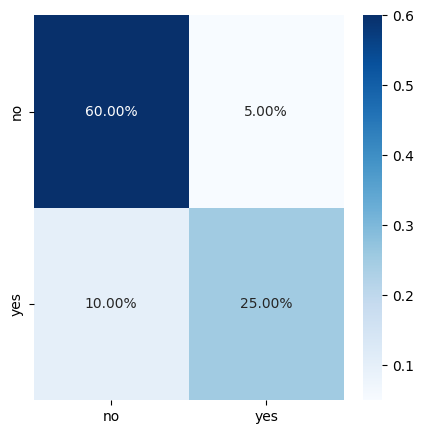

In [95]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    output = model(inputs)  # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)  # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)  # Save Truth

# constant for classes
classes = dataset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix), index=[i for i in classes],
                     columns=[i for i in classes])
plt.figure(figsize=(5, 5))

sn.heatmap(df_cm, annot=True, fmt='.2%', cmap='Blues')
plt.savefig('output.png')

The model, accuretly classifies 85% of the data. We can observe on the confusion matrix that 10% of the images containing a tumor is classified as not whereas only 5% of images not containing a tumor is classified as having one. The results of our model could be significantly improved by increasing the number of samples, for example by using data augmentation. The quality of the images could be impoved by cropping the edges and perhaps perfoming image segmentation. 

# Problem 4

## Introduction

In [103]:
#Import libraries
import skimage.io
from skimage import data,io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Load image
The image used in this problem is loaded from the skimage package and can be seen below.

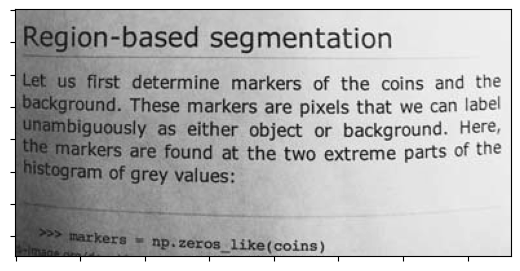

In [100]:
# Initialise random seed
rng = np.random.default_rng(None)

# Load image from skimage package 
image=data.page()

#Plot image
fig, ax = plt.subplots()

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(image,cmap='gray')


A function is created to produce each type of noise.For the:
* Uniform Noise: Different pixel values of noise are equally probably.For each pixel in the image, a random number is that follows the uniform distribution is generated and added to the image. 
* Gaussian Noise: For each pixel in the image, a random number is that follows the Gaussian distribution is generated and added to the image.The magnitude of the noise depends on the variance we choose.
* Salt and Pepper Noise: Each pixel is assigned randomly to 0(black or pepper) or 255 (white or salt). The amount is equal to the number of pixels we want to choose and  saltvspepper represents the proportion of salt versus pepper.

In [110]:
### Function implementing noise

def add_noise(image,noise_type,param):
    
    """
    :image: original image
    :noise_type: the type of noise. It can be ['uniform','gaussian','salt&pepper','none']
    :param: for gaussian noise parameters represent mean and variance and for salt and pepper
            noise they represent the amount and proportion of salt vs pepper
    :return:
    returns image with noise with values ranging from 0 to 255
    """
    
    if noise_type == 'uniform':
        #Convert image to float
        img=skimage.img_as_float(image)
        #Generate Uniform Noise
        noise=rng.uniform(0,1,image.shape)
        #Values outside the interval are clipped to the interval edges(0,1)
        out = np.clip(img+noise, 0, 1.0)
        return img_as_ubyte(out)

    elif noise_type == "gaussian":
        #Convert image to float
        img=skimage.img_as_float(image)
        #
        mean = param[0]
        var = param[1]
        #Generate Noise
        noise=rng.normal(mean, var** 0.5, image.shape)
        out = np.clip(img+noise, 0, 1.0)
        return img_as_ubyte(out)

    elif noise_type == "salt&pepper":
        #Convert image to float
        img=skimage.img_as_float(image)
        # Copy image
        out = np.copy(img)
        # Specify amount of noise and proportion of salt vs pepper
        amount=param[0]
        salt_vs_pepper=param[1]
        #Salt
        # Randomly pick some pixels in the
        # image for coloring them white
        # Salt mode
        num_salt = np.ceil(amount * image.size * salt_vs_pepper)
        for i in range(int(num_salt)):
            # Pick a random y coordinate
            y_coord=np.random.randint(0, out.shape[0] - 1)
            # Pick a random x coordinate
            x_coord=np.random.randint(0, out.shape[1] - 1)
            # Color that pixel to white
            out[y_coord][x_coord] = 1
        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1-salt_vs_pepper))
        for i in range(int(num_salt)):
            # Pick a random y coordinate
            y_coord=np.random.randint(0, out.shape[0] - 1)
            # Pick a random x coordinate
            x_coord=np.random.randint(0, out.shape[1] - 1)
            # Color that pixel to white
            out[y_coord][x_coord] = 0

        return img_as_ubyte(out)
    elif noise_type == "no":
        # No filter applied
        return img_as_ubyte(image)
    else:
        # Wrong type of noise or typo
        print("Wrong noise type")
        return img_as_ubyte(image)

In [111]:
#%%
#Image with uniform noise
un_param=[]
un_image=add_noise(image,'uniform',un_param)

#Image with gaussian noise
gaus_param=[0,0.01]
gaus_image=add_noise(image,'gaussian',gaus_param)

#Image with uniform noise
svsp_param=[0.1,0.8]
sp_image=add_noise(image,'salt&pepper',svsp_param)

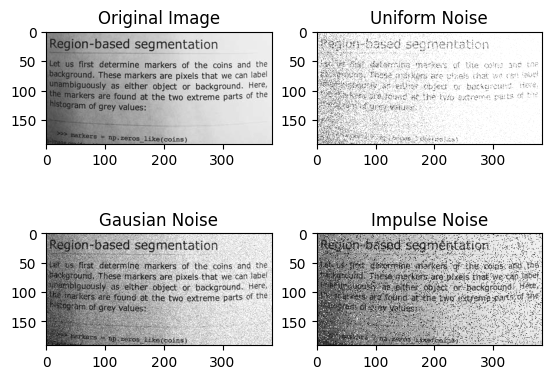

In [112]:
# Plot results
fig = plt.figure()

# Plot the original image
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(image,cmap='gray')

#Plot image with uniform noise
plt.subplot(2, 2, 2)
plt.title("Uniform Noise")
plt.imshow(un_image,cmap='gray')

#Plot image with gaussian noise
plt.subplot(2, 2, 3)
plt.title("Gausian Noise")
plt.imshow(gaus_image,cmap='gray')

#Plot image with salt&pepper noise
plt.subplot(2, 2, 4)
plt.title("Impulse Noise")
plt.imshow(sp_image,cmap='gray')

plt.show()

## Mean, median and Mode filter

* Mean Filter: The basic principle of mean filtering is to replace each pixel's value with the mean value of its neighbours, that also includes itself.Mean filters are similar to convolution filter in a way as it uses a kernel that be used to sample the neighboring pixels for the average. 
* Median Filter: The median filter is similar, but instead of the average of the neighboring pixels,we calculate the median.
* Mode filter: Mode filter replaces the pixel values in an image with the mode value of its neighbourhood pixels using a kernel as we mentioned above.

In [113]:
def filter_image(image,filter_type,filter_size):
    """

    :param image: original image 
    :param filter_type: can be ['mean','median','mode','no']
    :param filter_size: kernel size 3x3,5x5.......
    :return: filtered image
    """
    
    #Copy image
    img = np.copy(image)
    
    index= filter_size // 2
    if filter_type=="mean":
        for i in range(index, image.shape[0]-index):
            for j in range(1, image.shape[1]-index):
                block = image[i-index:i+index+1, j-index:j+index+1]
                m = np.mean(block,dtype=np.float32)
                img[i][j] = int(m)
        return img
    elif filter_type=="median":
        for i in range(index, image.shape[0]-index):
            for j in range(1, image.shape[1]-1):
                block = image[i-index:i+index+1, j-index:j+index+1]
                m = np.median(block)
                img[i][j] = m
        return img
    elif filter_type=='mode':
        for i in range(index, image.shape[0]-index):
            for j in range(index, image.shape[1]-index):
                block = image[i-index:i+index+1, j-index:j+index+1]
                m = stats.mode(block,axis=None,keepdims=False)
                img[i][j] = m[0]
        return img
    elif filter_type == "no":
        return img
    else:
        print("Wrong filter type name")

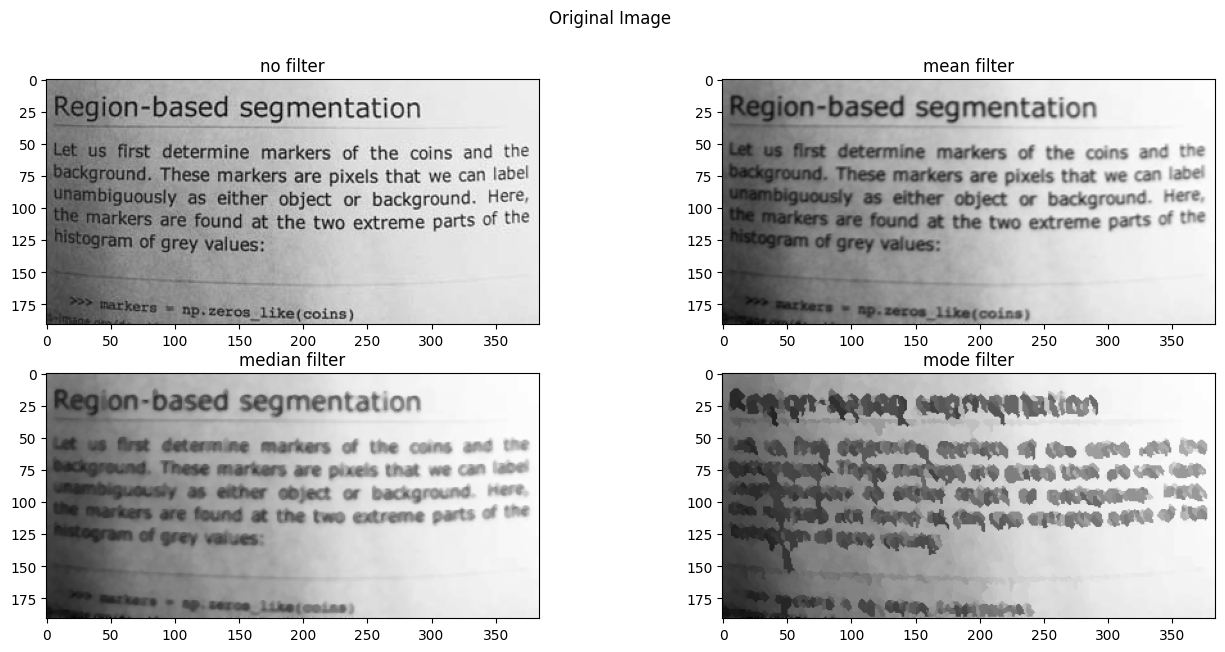

In [116]:
# Create list with filter types
filter_type=['no','mean','median','mode']

## Original Image
orig_img=data.page()

#Create figures
fig = plt.figure(figsize = (10,7))
# Create figures with different filters 
for i,filt in enumerate(filter_type):
    filt_img=filter_image(orig_img,filt,filter_size=3)
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(f'{filt} filter')
    ax.imshow(filt_img,cmap='gray')

fig.suptitle('Original Image')
plt.show()


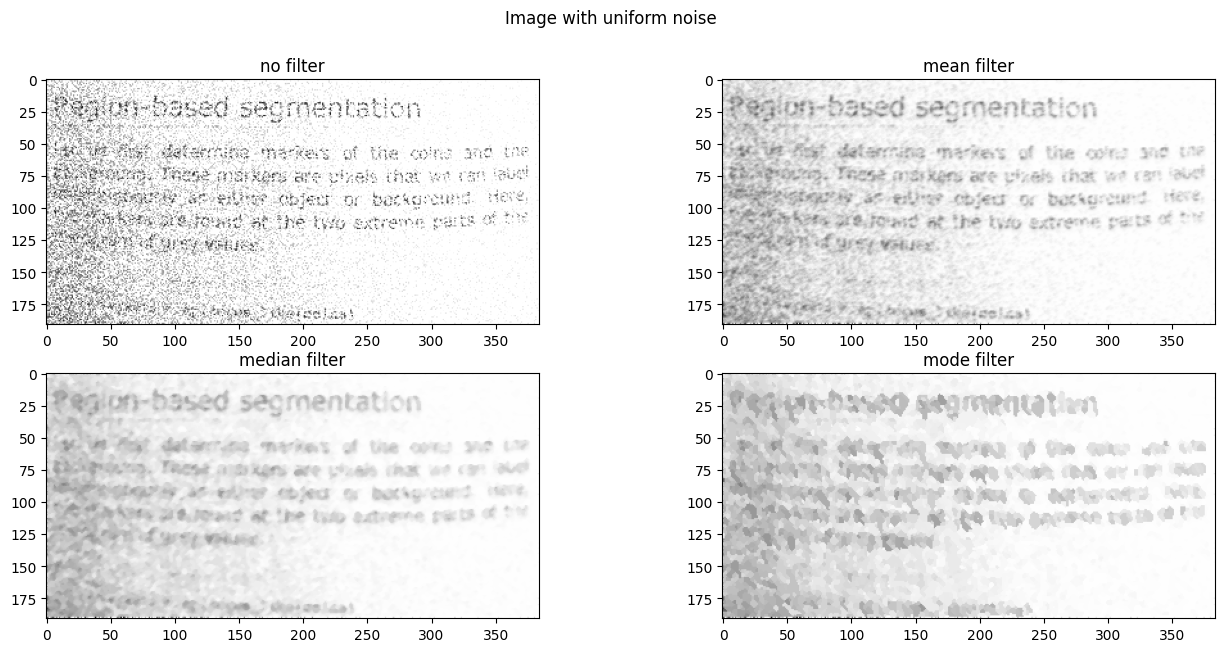

In [120]:
## Image with uniform noise
fig = plt.figure(figsize = (10,7))
i=1
for filt in filter_type:
    filt_img=filter_image(un_image,filt,filter_size=3)
    ax=fig.add_subplot(2,2,i)
    ax.set_title(f'{filt} filter')
    ax.imshow(filt_img,cmap='gray')
    i+=1

fig.suptitle('Image with uniform noise')
plt.show()


We can observe that for this type of noise the mean filter is the most suitable.

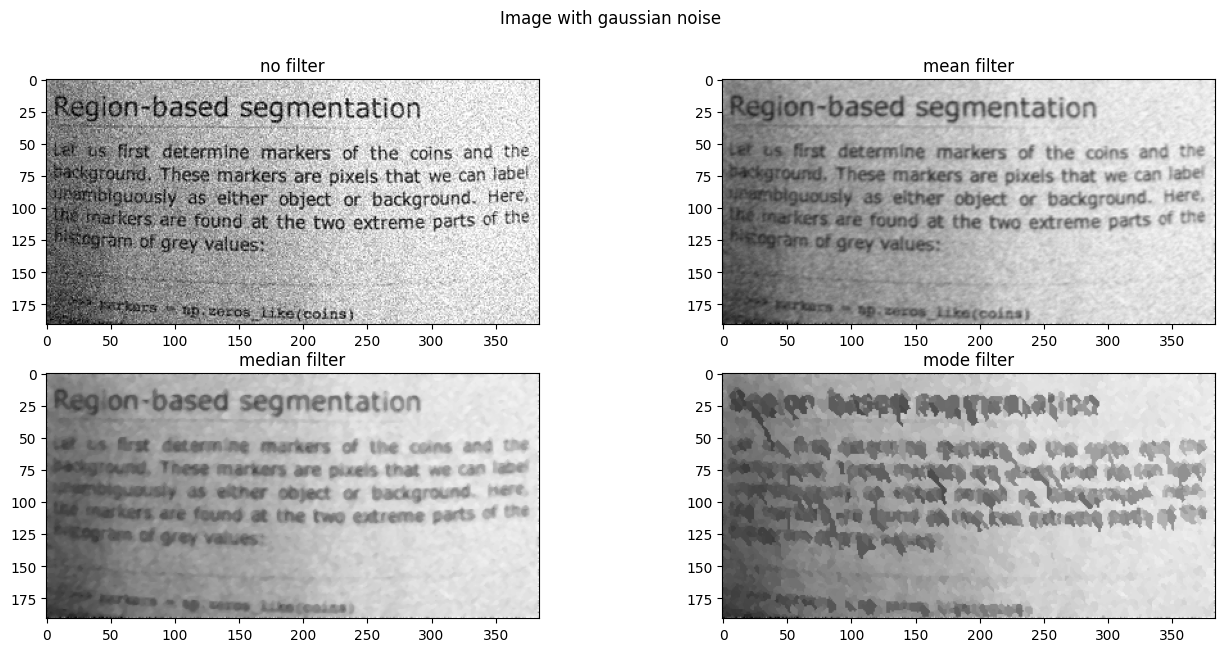

In [119]:
## Image with uniform noise

fig = plt.figure(figsize = (16,7))
i=1
for filt in filter_type:
    filt_img=filter_image(gaus_image,filt,filter_size=3)
    ax=fig.add_subplot(2,2,i)
    ax.set_title(f'{filt} filter')
    ax.imshow(filt_img,cmap='gray')
    i+=1

fig.suptitle('Image with gaussian noise')
plt.show()


The mean or median filters appear to me the most suitable for gausian noise.

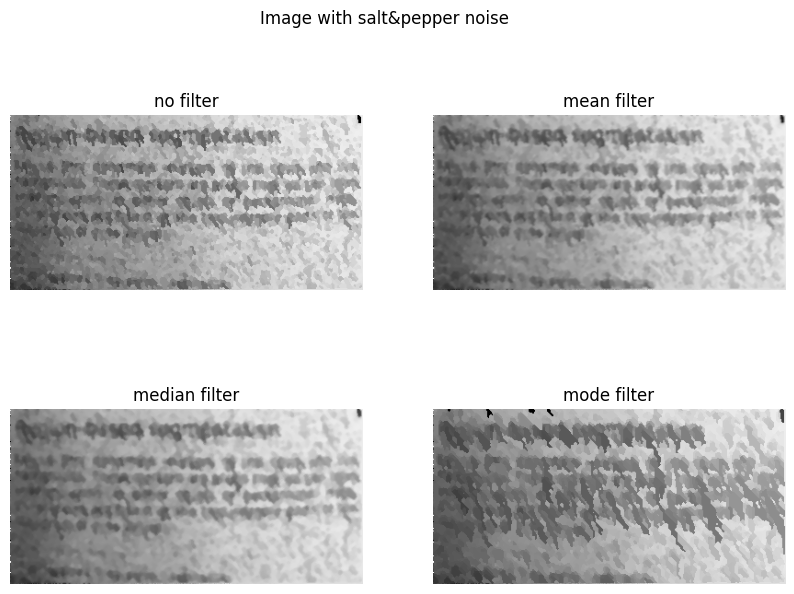

In [132]:
## Image with uniform noise
fig = plt.figure(figsize = (16,7))
i=1
for filt in filter_type:
    filt_img=filter_image(sp_image,filt,filter_size=3)
    ax=fig.add_subplot(2,2,i)
    ax.set_title(f'{filt} filter')
    ax.axis('off')
    ax.imshow(filt_img,cmap='gray')
    i+=1

fig.suptitle('Image with salt&pepper noise')
plt.show()


# 3

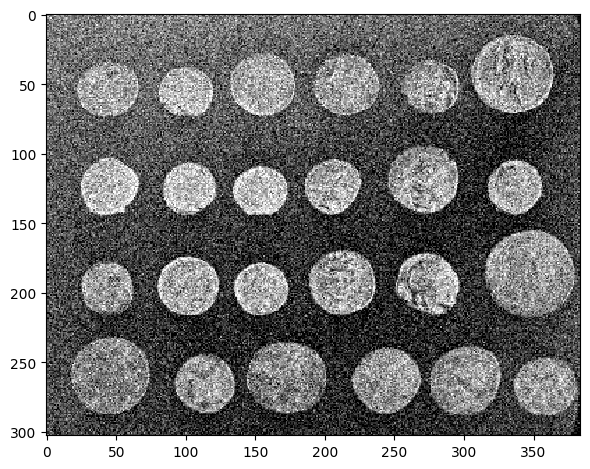

In [117]:
coin_img = data.coins ()
from skimage.util import random_noise
sigma = 0.155
noisy = random_noise(coin_img , var=sigma**2) 
io.imshow(noisy)

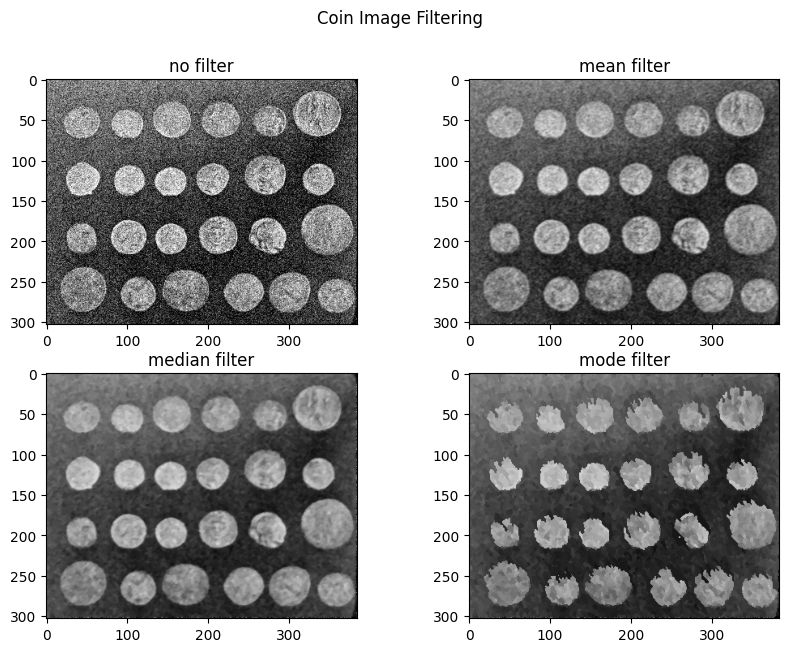

In [118]:
noisy=img_as_ubyte(noisy)

fig = plt.figure(figsize = (10,7))
i=1
for filt in filter_type:
    filt_img=filter_image(noisy,filt,filter_size=3)
    ax=fig.add_subplot(2,2,i)
    ax.set_title(f'{filt} filter')
    ax.imshow(filt_img,cmap='gray')
    i+=1

fig.suptitle('Coin Image Filtering')
plt.show()

# Problem 5
## Region-based segmentation:Seeded region growing.
### Introduction
The seeded region growing algorithm starts with a set of initial seeds $p_1,p_2,\dots,p_n$ that determine n clusters  $C_1, C_2,\dots,C_n,$.The selection of seed points depends on the user and the application. At each step, more points are added to the cluster by merging a pixel with 8-connected neighboring region $C_i$. in this particular instance, the difference in pixel values between the seed point and its neighbouring points will be used as the criterion to group pixels into various clusters. If the difference is smaller than the user preset threshold then we classify the point into the cluster $C_i$.

In [123]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2

### Select Seed points
The first function is used to select a set of seed points. The image is visualised usising opencv and the user can specify the coordinates of each point and the number of them.  For these examples, we selected 5 and 10 seed points, respectively. Each point is chosen so that it is indicative of the regions.

In [127]:
## Uncomment cell to generate new set seed points

# def on_mouse(event, x, y, flags, params):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print('Seed: ' + str(x) + ', ' + str(y), img[x, y])
#         clicks.append((int(y), int(x)))
#
#
# clicks = []
# cv2.namedWindow('Input')
# cv2.setMouseCallback('Input', on_mouse, 0, )
# cv2.imshow('Input', img)
# cv2.waitKey()
# seed = clicks
# cv2.destroyAllWindows()

### Calculate neighboring points
The function below is used to find the 8-neigbhoring points as it can be seen in the image below.

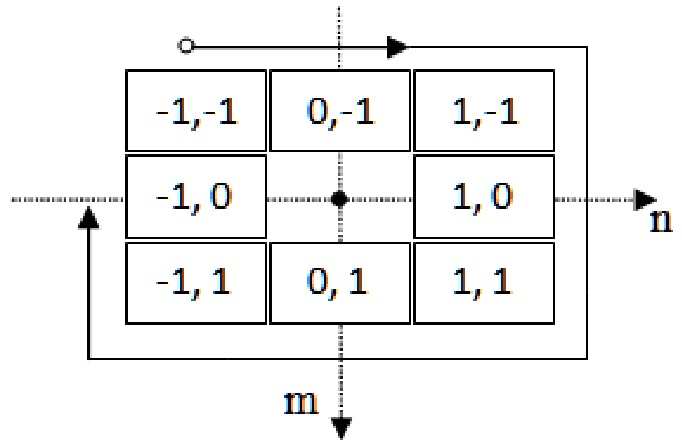

In [124]:
## Function to generate 8-neigbhoring points
## for each seed point

def neighboring_points(p, img_shape):
    """
    p: user defined seed point
    img_shape: original image shape
    return: Coordinates of neighboring pixels in a list
    """
    
    # Get seed coordinates
    x, y = p
    # Find image borders
    xmax = img_shape[0] - 1
    ymax = img_shape[1] - 1

    # Create list that will contain cluster(neighboring pixels)
    cluster = list()

    # Calculate coordinates of the pixels which surrounding the seed
    for dx in range(3):
        for dy in range(3):
            x_i = x + dx - 1  # dx-1 will result in -1,0,1
            y_i = y + dy - 1
            # Check if x_i and y_i are:
            #  -Within the boundaries of the picture,
            #  -Greater than zero
            #  -Are not equal to seed point the seed point
            if (x_i < 0 or x_i > xmax) or \
                    (y_i < 0 or y_i > ymax) \
                    or (x_i == x and y_i == y):
                pass
            else:
                cluster.append((x_i, y_i))
    return cluster




### Classify points
This function takes in each seed point as well as one of the neighboring points and returns boolean value which is true is the difference is smaller than the threshold and false otherwise.

In [146]:
def classify_points(seed, point, img, threshold):
    """

    seed: user defined seed point
    point: neighboring pixel
    img: original image
    threshold: user defined threshold
    :return: boolean value which is true is the 
    difference is smaller than the threshold and false otherwise.
    """
    # Seed coordinates
    seed_x, seed_y = seed
    x, y = point
    return abs(int(img[x, y]) - int(img[seed_x, seed_y])) < threshold


### Region growing.
This function combines all the above utility function in order to return the final image. The inputs are the original image, the user defined seed points and threshold. The process is the following:
* Create an empty array that is the same shape as the original image.
* Create a numpy array that’s filled with the False value.This array will be used to determine if a point has been processed or not.
* For each seed point, the corresponding pixel in the output array is set to it's value.
* A loop is created that will stop when there are no more seed points.
* For each seed and it's neighboring point, we check the difference and depending on the result the point is added to the cluster. If the point hasn't been processed it's added to the seed list. 
* The seed point is removed from the list after processing.

In [126]:
def region_growing(img, seeds, threshold):
    """
    img: initial image
    seeds:user defined seed points
    threshold: user defined threshold
    return: segmented image
    """

    # Create an empty array from the output image
    output = np.zeros_like(img)
    # Create an array with values that will be equal with:
    # True if the pixel was processed
    # False if the pixel wasn't processed
    processed = np.full((img.shape[0], img.shape[1]), False)

    # The cluster in the output will be marked by the pixel value in the original image
    for pixel in seeds:
        # Change value to true
        processed[pixel[0], pixel[1]] = True
        output[pixel[0], pixel[1]] = img[pixel[0], pixel[1]]

    while (len(seeds) > 0):
        # Initial seed point
        seed = seeds[0]
        for point in neighboring_points(seed, img.shape):
            if not processed[point[0], point[1]]:
                # Classify point into cluster
                test_result = classify_points(seed, point, img, threshold)
                # If true
                if test_result:
                    output[point[0], point[1]] = output[seed[0], seed[1]]
                    if not processed[point[0], point[1]]:
                        seeds.append(point)
                    processed[point[0], point[1]] = True
        # Remove item at 0 from the list
        seeds.pop(0)
    return output



### Load example images
In order to test our function, we will use two images that can be found on kaggle in the Brain MRI Images dataset for [Brain Tumor Detection]. The image 

/var/folders/3y/3k_hrx6d5d10jv_0k1vzfqt80000gn/T/ipykernel_2386/2675644364.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


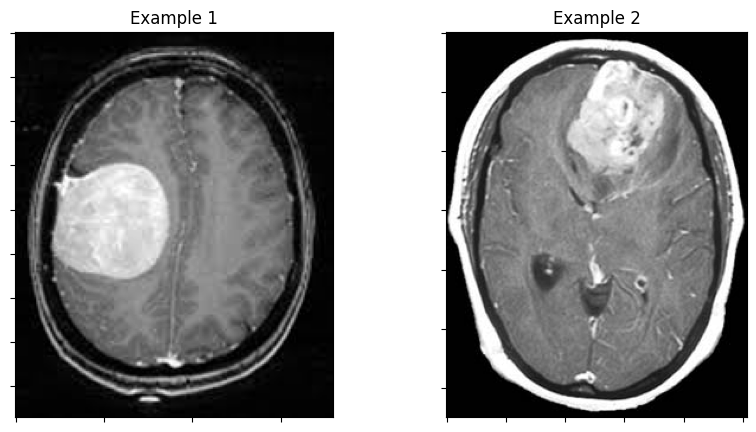

In [195]:
filepath = '/Users/papagiannizoe/Desktop/MSc-Imperial/Term _4/Unstructured_Data/Assessments/Assessment_1/data/yes'
img_float = io.imread(filepath+'/Y1.jpg', as_gray=True)
img = (img_float * 255).astype('uint8')

## Second image example
img_float = io.imread(filepath+'/Y13.jpg', as_gray=True)
img_2 = (img_float * 255).astype('uint8')

## Visualise Images

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)   

# Get the values of min and max intensity in the original image
vmin = img.min()
vmax = img.max()

# Subplot axes
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.subplot(1, 2, 1)
ax1.set_title("Example 1")
ax1.imshow(img, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

plt.subplot(1, 2, 2)
ax2.set_title("Example 2")
ax2.imshow(img_2, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

plt.show()

### Visualise Seeds on Example 1

/var/folders/3y/3k_hrx6d5d10jv_0k1vzfqt80000gn/T/ipykernel_2386/3173563967.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


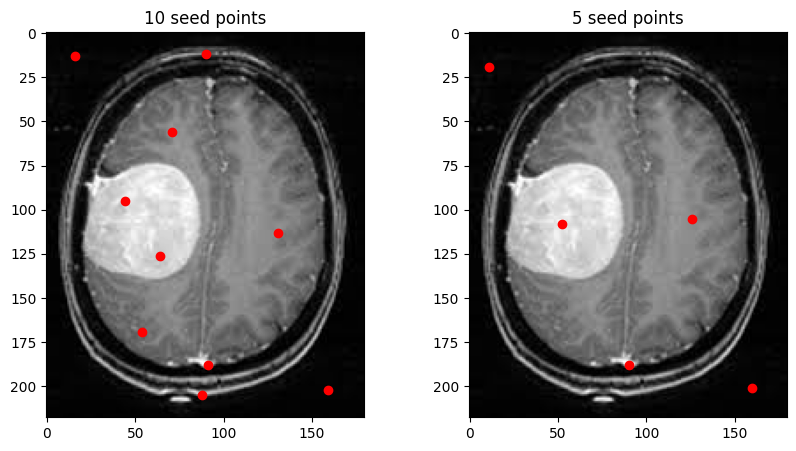

In [196]:
# Define seed points
# The points where chosen using the function above
user_seeds1=[(13, 16), (202, 159), (188, 91), (95, 44), (126, 64), (56, 71), (113, 131), (169, 54), (205, 88), (12, 90)]
user_seeds2=[(19, 11), (201, 160), (188, 90), (108, 52), (105, 126)]


#Visualize Seeds
x_1 = [x[1] for x in user_seeds1]
y_1 = [x[0] for x in user_seeds1]

x_2 = [x[1] for x in user_seeds2]
y_2 = [x[0] for x in user_seeds2]

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)

#First column
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.subplot(1, 2, 1)
ax1.set_title("10 seed points")
ax1.scatter(x_1, y_1, color="red")
ax1.imshow(img, cmap=plt.cm.gray)

plt.subplot(1, 2, 1)
ax2.set_title("5 seed points")
ax2.scatter(x_2, y_2, color="red")
ax2.imshow(img, cmap=plt.cm.gray)

plt.show()

We choose to test our image with a threshold of 10 and 20.  These values were chosen because it appears that the regions are homogeneous throughout and that there isn't a lot of variation in the pixel value within one region.

In [197]:
#Apply SRG algorithm
out_trial1 = region_growing(img, user_seeds1,threshold=10)
out_trial2 = region_growing(img, user_seeds2,threshold=10)

user_seeds1=[(13, 16), (202, 159), (188, 91), (95, 44), (126, 64), (56, 71), (113, 131), (169, 54), (205, 88), (12, 90)]
user_seeds2=[(19, 11), (201, 160), (188, 90), (108, 52), (105, 126)]

#Apply SRG algorithm
out_trial3 = region_growing(img, user_seeds1,threshold=20)
out_trial4 = region_growing(img, user_seeds2,threshold=20)

/var/folders/3y/3k_hrx6d5d10jv_0k1vzfqt80000gn/T/ipykernel_2386/3174673962.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 1)


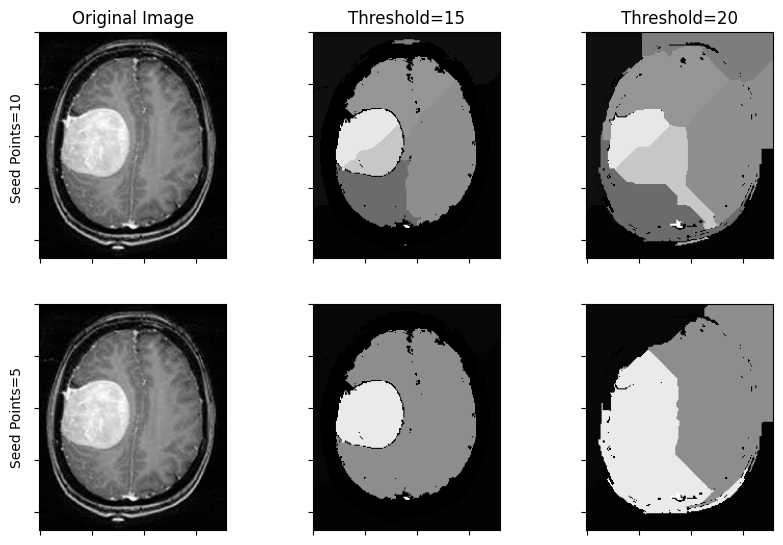

In [198]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)   

#First column
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(334)

#First row
ax3 = fig.add_subplot(332)
ax4 = fig.add_subplot(333)

ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)

# Set common labels
ax1.set_ylabel('Seed Points=10 ')
ax2.set_ylabel('Seed Points=5')

ax1.set_title('Original Image',)
ax3.set_title('Threshold=10')
ax4.set_title('Threshold=20')

plt.subplot(3, 3, 1)
plt.imshow(img,cmap='gray')

plt.subplot(3, 3, 2)
plt.imshow(out_trial1,cmap='gray')

plt.subplot(3, 3, 3)
plt.imshow(out_trial3,cmap='gray')

plt.subplot(3, 3, 4)
plt.imshow(img,cmap='gray')

plt.subplot(3, 3, 5)
plt.imshow(out_trial2,cmap='gray')

plt.subplot(3, 3, 6)
plt.imshow(out_trial4,cmap='gray')

# Remove tick labels
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax6.set_xticklabels([])
ax6.set_yticklabels([])

plt.show()


The 10 seed points appear to provide the best result in both cases, based on the figure above. Given that both cases produce good outcomes, it appears that 10 is the best threshold value. However, the algorithm is unable to identify the skull in both situations. Additionally, it appears that a threshold of 20 is set too high, which results in poor segmentation.

/var/folders/3y/3k_hrx6d5d10jv_0k1vzfqt80000gn/T/ipykernel_2386/2899624587.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


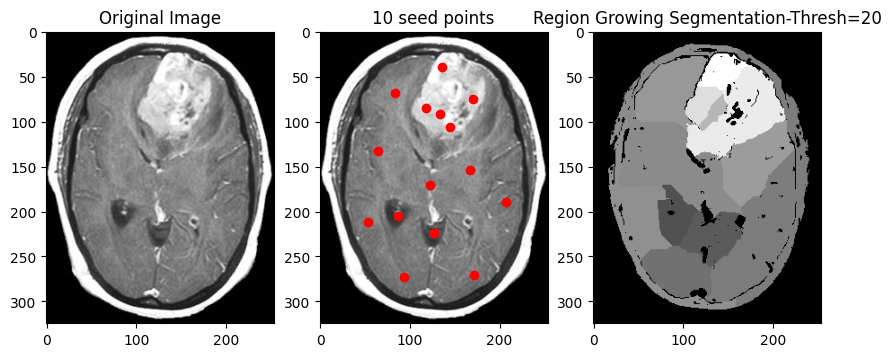

In [185]:
# %%
seeds=[(39, 136), (85, 118), (106, 145), (75, 170), (68, 84), (133, 64), (212, 53), (273, 94), (271, 171), (189, 207), (154, 167), (224, 127), (205, 87), (170, 123), (91, 134)]
#Visualize Image Resolutions
x = [x[1] for x in seeds]
y = [x[0] for x in seeds]

out_2 = region_growing(img_2, seeds,threshold=10)

fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)

#First column
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

plt.subplot(1, 3, 1)
ax1.set_title("Original Image")
ax1.imshow(img_2,cmap='gray')

plt.subplot(1, 3, 1)
ax2.set_title("10 seed points")
ax2.scatter(x, y, color="red")
ax2.imshow(img_2, cmap=plt.cm.gray)

plt.subplot(1, 3, 2)
ax3.set_title("Region Growing Segmentation-Thresh=10")
ax3.imshow(out_2,cmap='gray')

In this particular case, we chose 10 seed points and a threshold of 20. Although the skull is still not recognised as a distinct region, the outcome is quite good.

## K-Means Clustering
### Introduction
There are segmentation methods based on techniques other than thresholding and region growing—for example, edge-based segmentation which relies on edge detection. Find one of them, describe the method, code the program and implement the segmentation on any image.

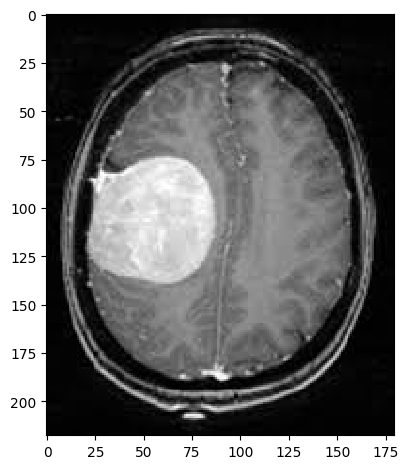

In [199]:
# %%
# Input
# Read the data as greyscale
filepath = '/Users/papagiannizoe/Desktop/MSc-Imperial/Term _4/Unstructured_Data/Assessments/Assessment_1/data/yes'
img_float = io.imread(filepath + '/Y1.jpg', as_gray=True)
img = (img_float * 255).astype('uint8')
io.imshow(img)

### Initialise centroids
The function accepets the original image and the number of clusters we want to indetify. We produce random integers that are within the image boundaries and return the pixel value for each centroid.

In [203]:
# Randomly initialise cluster centroids
def init_cenrtoids(img, n_clusters):
    xmax = img.shape[0] - 1
    ymax = img.shape[1] - 1
    # Array of sample indices for each cluster
    centroid = []
    for k in range(n_clusters):
        # Pick a random y coordinate
        x = np.random.randint(0, xmax)
        # Pick a random x coordinate
        y = np.random.randint(0, ymax)
        centroid.append(img[x, y])
    return centroid



### Euclidean Distance
The function accepts the pixel and centroid value. The distance for a grayscale image is defined as:
$$||d = p(x, y) − c_i|| $$ .
The function returns the distances of the pixel from each centroid.

In [204]:
# Calculate distance.
def eu_distance(pixel, centroids):
    dist = []
    for cent in centroids:
        dist.append(abs(int(pixel) - int(cent)))
    return np.array(dist)



### Update Centres
The function accepts the number of clusters, the image array with values that correspond to the cluster each pixel belongs and the original image. The function calculates the mean of the pixel values for each group as so:
$$c_k=\frac{1}{k}\sum_{y \in k}\sum_{x \in k} p(x,y) $$

In [205]:
# %%
def update_centers(n_clusters, cluster_idx, img):
    new_centers = []
    for i in range(n_clusters):
        new_centers.append(np.mean(img[cluster_idx == i]))
    return new_centers



### Loss function 
The loss function calculates the sum of the distances divided by the image shape. 

In [206]:
# %%
def error_value(centroids, cluster_idx, img):  # [5 pts]
    loss = 0.0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            loss = loss + abs(img[x, y] - centroids[int(cluster_idx[x, y])])
    loss = loss / img.size
    return loss



### Main function
The function uses all the utility functions from above. It accepts the original image,the number of clusters, the number of maximum iterations, the absolute error and a flag variable that is True when we want to print the results and False otherwise. 

In [207]:
##K means clusterings
def kmeans_seg(img, k, iterations, abs_error,stats):
    #Initialise lose
    prev_loss = 0
    #Initialise centrois
    centroids = init_cenrtoids(img, k)
    #Create empty array that will be used as a mask
    # the values correspond to each pixel in the image and
    # will be equal to the group they are classified. 
    cluster_idx = np.zeros(img.shape)

    for i in range(iterations):
        # For each pixel calculate Euclidean distance between each center.
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                dist = eu_distance(img[x, y], centroids)
                # Assign each pixel to the nearest centre
                cluster_idx[x, y] = np.argmin(dist)
        # Update centroids
        new_centroids = update_centers(k, cluster_idx, img)
        # In case a cluster is empty it sets a random pixel to that cluster
        for index,elem in enumerate(new_centroids):
            if np.isnan(elem):
                x=np.random.randint(0, img.shape[0] - 1)
                y=np.random.randint(0, img.shape[1] - 1)
                new_centroids[index]=img[x,y]
        #Calculate loss
        error = error_value(new_centroids, cluster_idx, img)
        # Find difference loss for previous centroids
        diff = abs(prev_loss - error)
        #Break look when we reach the desired error value
        if diff <= abs_error:
            break
        # Set values to new loss and centroids
        prev_loss = error
        centroids=new_centroids
        #Print loss and iteration index
        if stats:
            print('iter %d, loss: %.4f' % (i, diff))
    return centroids, cluster_idx



### Image segmetation
The function accepts the original image, the pixel value of the centroids and the labels. It returns the segmented image.

In [208]:
def seg_image(img,values,labels):
    img_segm = np.copy(img)
    # assign each pixel to cluster mean
    for i in range(len(values)):
        indices_current_cluster = np.where(labels == i)
        img_segm[indices_current_cluster] = values[i]

    return img_segm

In [210]:
# Group similar grey levels using 8 clusters
iterations = 1000
abs_error = 1e-16

# 2 Clusters
n_clusters = 3
values, labels= kmeans_seg(img, n_clusters, iterations,abs_error,stats=True)
imgsegm_2 = seg_image(img,values,labels)

# 3 Clusters
n_clusters = 4
values, labels= kmeans_seg(img, n_clusters, iterations,abs_error,stats=False)
imgsegm_3 = seg_image(img,values,labels)

# 4 Clusters
n_clusters = 5
values, labels = kmeans_seg(img, n_clusters, iterations,abs_error,stats=False)
imgsegm_4 = seg_image(img,values,labels)

iter 0, loss: 14.0556
iter 1, loss: 0.1045
iter 2, loss: 0.0323
iter 3, loss: 0.0031


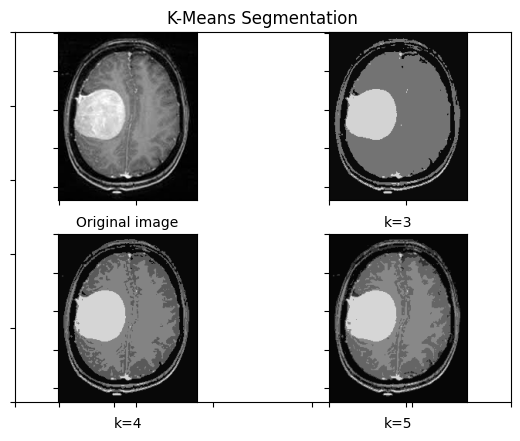

In [214]:
# Get the values of min and max intensity in the original image
vmin = img.min()
vmax = img.max()

fig = plt.figure(1)
ax = fig.add_subplot(111)

plt.title("K-Means Segmentation")
# Plot the original image
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(img, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax1.set_xlabel('Original image')

# Plot image with 2 clusters
ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(imgsegm_2, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax2.set_xlabel('k=3')

# Plot image with 2 clusters
ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(imgsegm_3, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax3.set_xlabel('k=4')

# Plot image with 2 clusters
ax4 = fig.add_subplot(2, 2, 4)
ax4.imshow(imgsegm_4, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax4.set_xlabel('k=5')


# Get rid of the tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax4.set_xticklabels([])
ax4.set_yticklabels([])

plt.show()

On the figure, we can see that the algorithm performs very well. Particularly, we can see that the image resembles the original one for k=5.